In [1]:
import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFile
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import pytorch_lightning as pl
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer

# Register matplotlib converters
pd.plotting.register_matplotlib_converters()

# IPython magic commands (for Jupyter notebooks)
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing custom help tool
from help_tool import help_tool

In [2]:
train_dir = 'Archive\Split\Train'
path = Path(train_dir)

classes  = [entry.name for entry in path.iterdir() if entry.is_dir()]
classes 

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

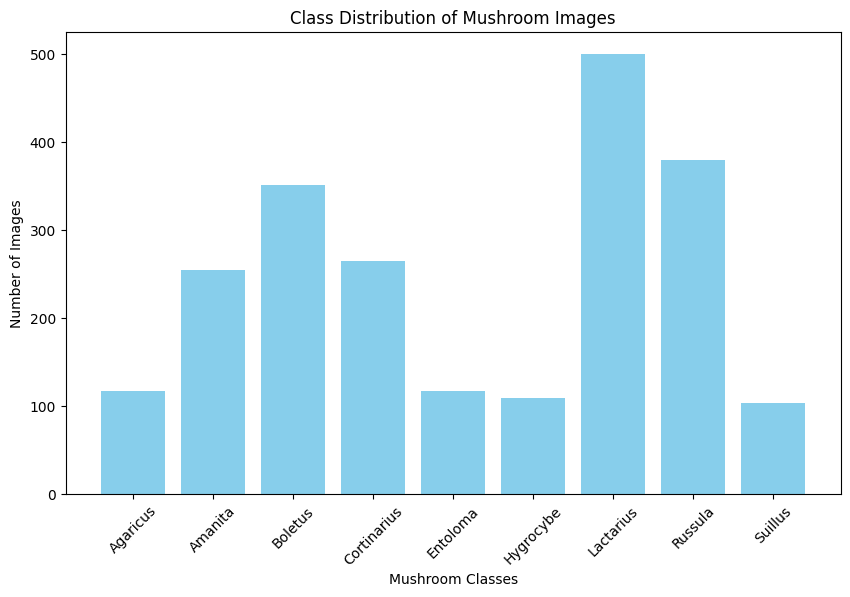

In [3]:
help_tool.plot_image_distribution(train_dir)

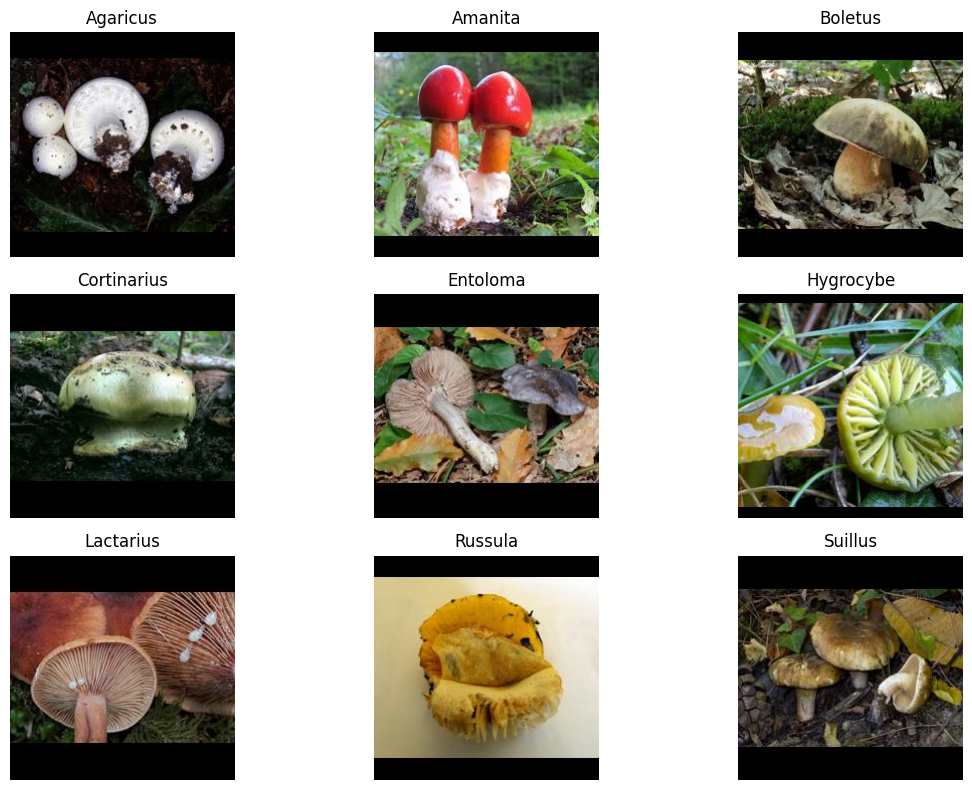

In [4]:
help_tool.visualize_sample_images(train_dir)

In [5]:
batch_size = 16

# Data Transformations

Define Data Augmentation

In [6]:
# # Define the ImageDataGenerator
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=50,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

train_datagen = ImageDataGenerator(
    featurewise_center=True,           # Center the data by subtracting the mean of each feature
    featurewise_std_normalization=True, # Normalize each feature by dividing by its standard deviation
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=20.0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    rescale=1.0/255
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

Convert Generators to PyTorch Tensors

In [7]:
validate_dir = 'Archive/Split/Validate'

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validate_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2196 images belonging to 9 classes.
Found 2060 images belonging to 9 classes.


c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


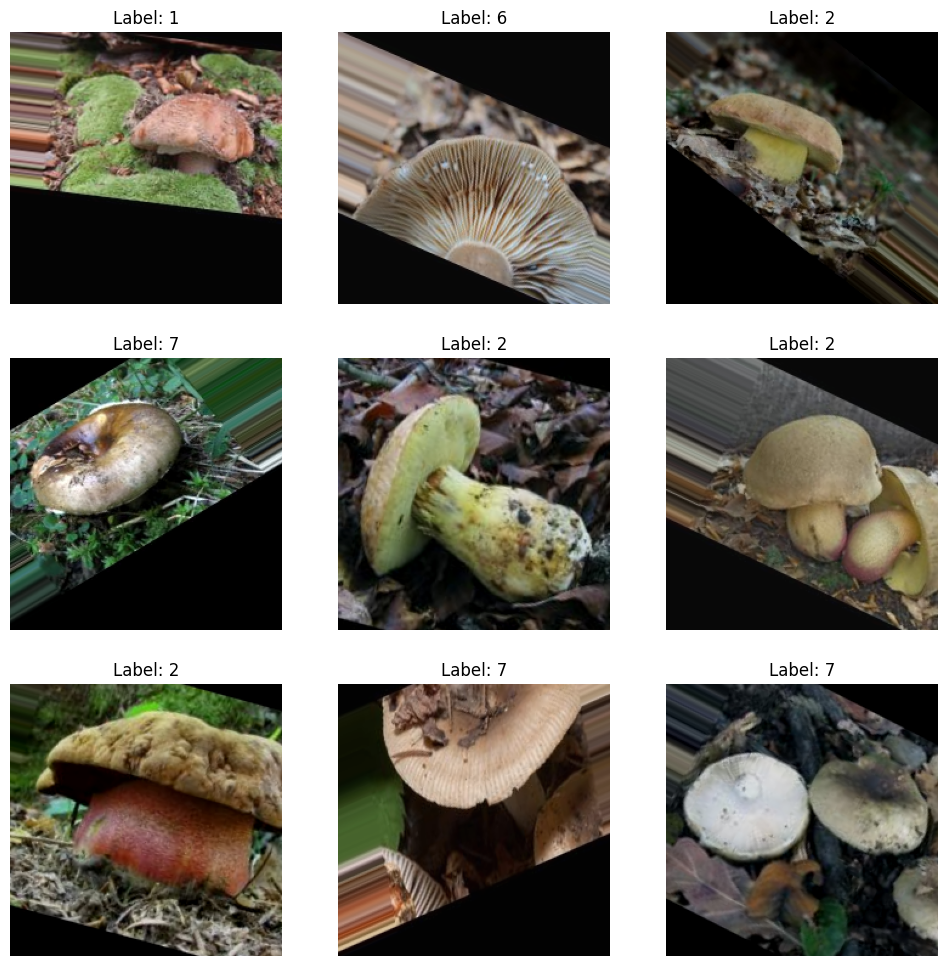

In [9]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Plot a few images
plt.figure(figsize=(12, 12))
for i in range(9):  # Displaying first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {np.argmax(labels[i])}')
    plt.axis('off')

plt.show()


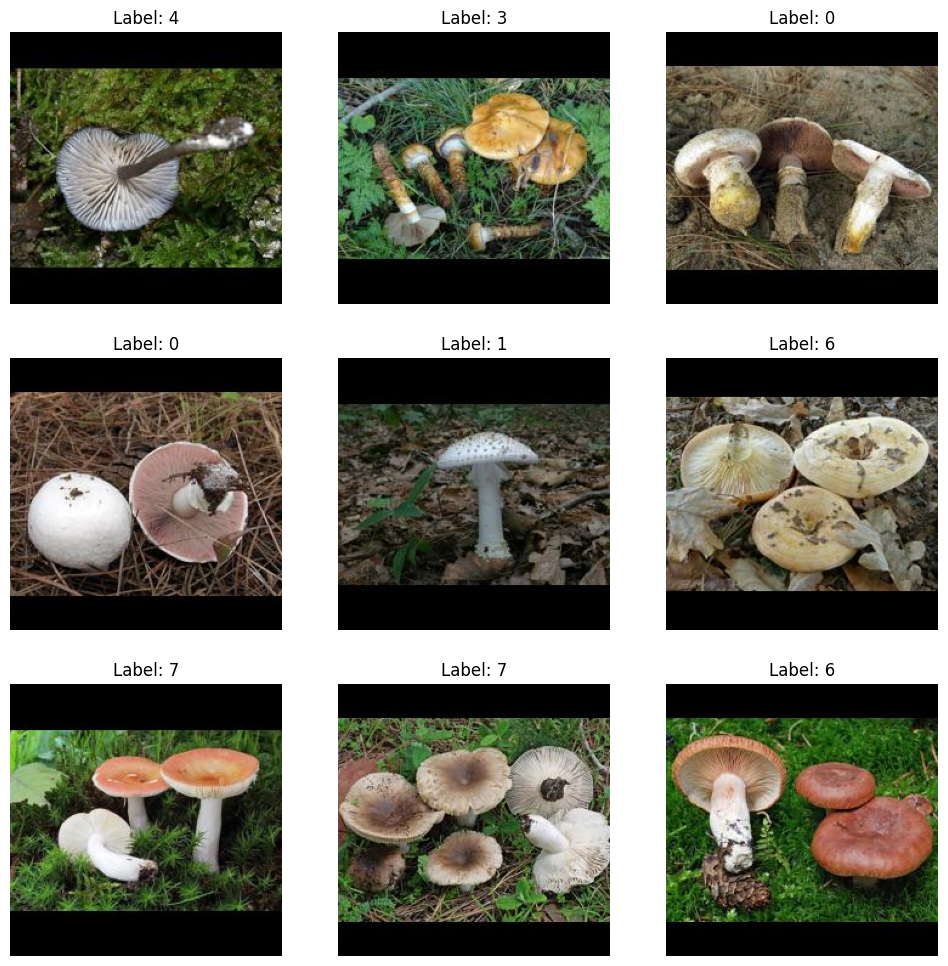

In [10]:
# Get a batch of images and labels
images, labels = next(val_generator)

# Plot a few images
plt.figure(figsize=(12, 12))
for i in range(9):  # Displaying first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {np.argmax(labels[i])}')
    plt.axis('off')

plt.show()


Create Data Generators

In [11]:
class KerasImageDataset(Dataset):
    def __init__(self, keras_generator):
        self.generator = keras_generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        x = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch tensor and reorder dimensions
        y = torch.tensor(np.argmax(y, axis=1), dtype=torch.long)  # Convert to PyTorch tensor and get class indices
        return x[0], y[0]

train_dataset = KerasImageDataset(train_generator)
val_dataset = KerasImageDataset(val_generator)

Data Loaders

In [25]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=23, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=23, shuffle=False)

In [13]:
train_loader

# Dummy Model
Dummy model with FastAI shows 70% Accuracy.

In [14]:
from fastai.vision.all import *

# Step 1: Load your data
path = Path('Archive\Split')
dls = ImageDataLoaders.from_folder(path, train='Train', valid='Validate', item_tfms=Resize(224))


In [15]:
# Step 2: Create a learner with appropriate metrics
learn = vision_learner(
    dls, 
    resnet18, 
    metrics=[
        accuracy, 
        Precision(average='macro'), 
        Recall(average='macro'), 
        F1Score(average='macro')
    ]
)

# Step 3: Train the model
learn.fine_tune(epochs=5)

# Step 4: Evaluate the model
results = learn.validate()
print(f"Validation results - Loss: {results[0]:.2f}, Accuracy: {results[1]:.2f}, Precision: {results[2]:.2f}, Recall: {results[3]:.2f}, F1 Score: {results[4]:.2f}")


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.500166,1.278349,0.596116,0.527455,0.536256,0.525051,01:17


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.303585,1.114574,0.645631,0.605445,0.592114,0.595612,01:36
1,0.891185,1.073376,0.678641,0.642535,0.626509,0.629607,01:36
2,0.549207,1.017374,0.699029,0.667775,0.641451,0.650585,01:36
3,0.319367,0.981927,0.710680,0.680572,0.652812,0.660552,01:36
4,0.198195,0.979967,0.718932,0.685616,0.665017,0.671084,01:36


Validation results - Loss: 0.98, Accuracy: 0.72, Precision: 0.69, Recall: 0.67, F1 Score: 0.67


In [16]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Suillus\\068_vev9iMcQQU8.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

Prediction: Lactarius, Probability: 0.6334


In [17]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Lactarius\\0057_vo2wCaUiwF0.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

Prediction: Lactarius, Probability: 0.5023


In [18]:
# Step 5: Make predictions
img = PILImage.create('Archive\Split\Test\Lactarius\\0057_vo2wCaUiwF0.jpg')
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

# Step 6: Save and load the model
learn.save('model_name')
learn.load('model_name')

Prediction: Lactarius, Probability: 0.5023


# Model

In [19]:
len(classes)

9

Load and Modify ResNet18:
* models.resnet18(pretrained=True) loads the pretrained ResNet18 model.
* self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) replaces the final fully connected layer to output the correct number of classes.

Define the LightningModule:
* forward: Defines the forward pass.
* training_step: Computes the training loss.
* validation_step: Computes the validation loss.
* configure_optimizers: Configures the optimizer.

Train the Model:
* Trainer(max_epochs=10): Creates a Trainer object to train the model for 10 epochs.
* trainer.fit(model, train_loader, val_loader): Starts the training process using the specified training and validation data loaders.

* ADAM: Combines weight decay with the gradient update, which can result in a less effective regularization method because the weight decay term is scaled by the learning rate and the adaptive moment estimates.
* ADAMW: Decouples weight decay from the gradient update, applying it directly to the weights after the gradient update. This approach leads to a more effective regularization method that can improve model generalization and is conceptually clearer.

In [23]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [30]:
class MyLightningModule(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()
        
        self.model = models.resnet18(weights=True)
        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)
        
        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)
        
        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)
        
        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

# Instantiate the model
num_classes = len(classes)
model = MyLightningModule(num_classes=num_classes, learning_rate=1e-1, weight_decay=1e-1, scheduler_step_size=10, scheduler_gamma=0.1)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',  
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'  # Ensure 'val_accuracy' is used here as well
)

# Assuming train_loader and val_loader are already defined DataLoader instances
trainer = Trainer(max_epochs=35, 
                  callbacks=[checkpoint_callback], 
                  log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 9: 'val_accuracy' reached 0.16279 (best 0.16279), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=00-val_accuracy=0.16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 18: 'val_accuracy' reached 0.27907 (best 0.27907), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=01-val_accuracy=0.28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 27: 'val_accuracy' reached 0.32558 (best 0.32558), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=02-val_accuracy=0.33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 36: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 45: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 54: 'val_accuracy' reached 0.34109 (best 0.34109), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=05-val_accuracy=0.34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 63: 'val_accuracy' reached 0.36434 (best 0.36434), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=06-val_accuracy=0.36.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 72: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 81: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 90: 'val_accuracy' reached 0.38760 (best 0.38760), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=09-val_accuracy=0.39.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 99: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 108: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 117: 'val_accuracy' reached 0.41860 (best 0.41860), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\mushroom-classifier-epoch=12-val_accuracy=0.42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 126: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 135: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 144: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 153: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 162: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 171: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 180: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 189: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 198: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 207: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 216: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 225: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 234: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 243: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 252: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 261: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 270: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 279: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 288: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 297: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 306: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 315: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


In [34]:
model = MyLightningModule.load_from_checkpoint("checkpoints\mushroom-classifier-epoch=12-val_accuracy=0.42.ckpt")

In [40]:
from pytorch_lightning import Trainer

# Load the model from checkpoint
model = MyLightningModule.load_from_checkpoint("checkpoints\mushroom-classifier-epoch=12-val_accuracy=0.42.ckpt")

# Create an optimizer instance as per the model's configuration
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  # lr is initial, real lr is in state_dict

# Load the optimizer state into the new optimizer
optimizer.load_state_dict(checkpoint['optimizer_states'][0])

# Inspect the learning rate from the optimizer state
for param_group in optimizer.param_groups:
    print(f"Learning rate: {param_group['lr']}")


Learning rate: 0.010000000000000002


In [44]:
checkpoint.get('epoch', None)

12

In [48]:
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.utils.data import DataLoader


model.eval()  # Set the model to evaluation mode

# Define metrics
num_classes = model.hparams.num_classes
accuracy = Accuracy(task='multiclass', num_classes=num_classes)
precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')

# Prepare your DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

# Evaluate the model
for batch in val_loader:
    x, y = batch
    with torch.no_grad():
        y_hat = model(x)
        # Compute metrics
        accuracy.update(y_hat, y)
        precision.update(y_hat, y)
        recall.update(y_hat, y)
        f1.update(y_hat, y)

# Compute final metrics
print(f"Accuracy: {accuracy.compute()}")
print(f"Precision: {precision.compute()}")
print(f"Recall: {recall.compute()}")
print(f"F1 Score: {f1.compute()}")


checkpoint.keys()